In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy
 
#eazy.symlink_eazy_inputs()

eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', path_is_env=False)

field = 'goodss'
n = 2



/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
params = {}
#params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.3.cat'%field
#params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.3.nzpcat'%field
#params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cat

if n == 0:
    params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
    params['TEMP_ERR_FILE'] = 'templates/TEMPLATE_ERROR.eazy_v1.0'
    params['WAVELENGTH_FILE'] = 'templates/lambda_v1.1.def'
    params['TEMPLATES_FILE'] = 'templates/tweak_cosmos_v4_spectra.param'
    params['PRIOR_FILE'] = 'templates/prior_K_zmax7.dat'
    if field == 'goodss': params['PRIOR_FILTER'] = 37
    elif field == 'goodsn': params['PRIOR_FILTER'] = 226
if n == 1:
    params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
    params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'

if n == 2:
    params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.3.cat'%field
    params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'
    params['PRIOR_FILTER'] = 205
    
if n == 3:
    params['TEMPLATES_FILE'] = 'templates/tweak_cosmos_v4_spectra.param'
    params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Catalog/%s_3dhst.v4.1.cat'%(field, field)
    
    
    
#params['MAIN_OUTPUT_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_v4.4'%field
params['MAIN_OUTPUT_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_t_3dhst.v4.4'%(field)

# Galactic extinction
params['MW_EBV'] = 0.0103
params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.
params['PRIOR_ABZP'] = 25.000


#params['PRIOR_FILTER'] = 205 # HST H-band
#params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'
#params['PRIOR_FILE'] = 'templates/prior_K_zmax7.dat'
#params['PRIOR_FILTER'] = 226
#params['PRIOR_FILTER'] = 37
#params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
#params['TEMP_ERR_FILE'] = 'templates/TEMPLATE_ERROR.eazy_v1.0'
#params['WAVELENGTH_FILE'] = 'templates/lambda_v1.1.def'
#params['TEMPLATES_FILE'] = 'templates/eazy_v1.1_lines.spectra.param'
#params['TEMPLATES_FILE'] = 'templates/tweak_cosmos_v4_spectra.param'
#params['WAVELENGTH_FILE'] = 'templates/EAZY_v1.1_lines/lambda_v1.1.def'
#params['TEMP_ERR_FILE'] = 'templates/TEMPLATE_ERROR.eazy_v1.0'

params['TEMP_ERR_A2'] = 0.500
params['SYS_ERR'] = 0.02
params['FIX_ZSPEC'] = False

Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst_temp.v4.3.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_J e_J ( 34): ESO/isaac_j.res
f_F140W e_F140W (204): hst/wfc3/IR/f140w.dat
f_H e_H ( 36): ESO/isaac_h.res
f_Ks e_Ks ( 37): ESO/isaac_ks.res
f_IRAC1 e_IRAC1 ( 18): IRAC/irac_tr1_2004-08-09.dat
f

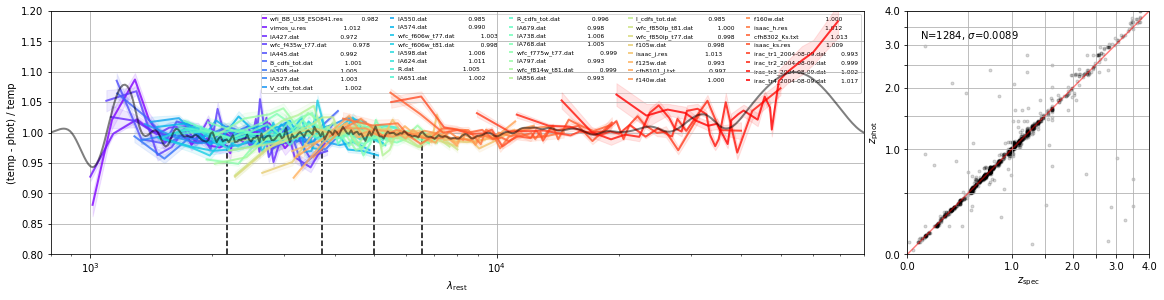

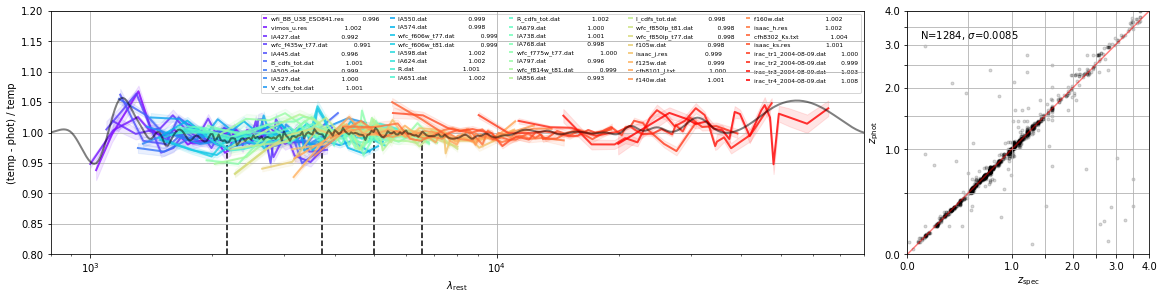

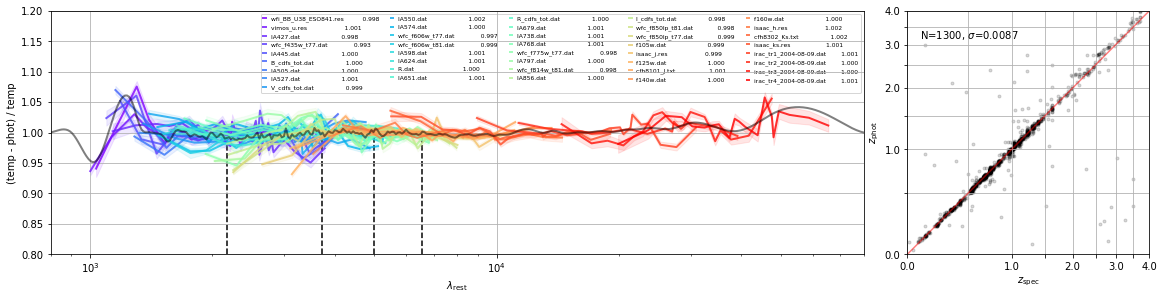

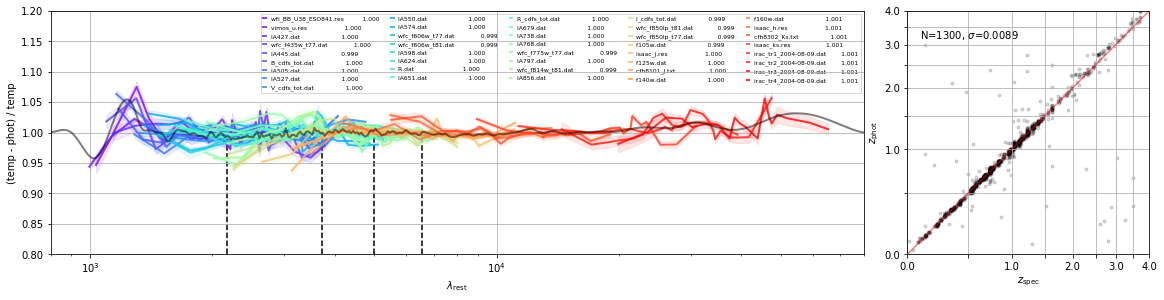

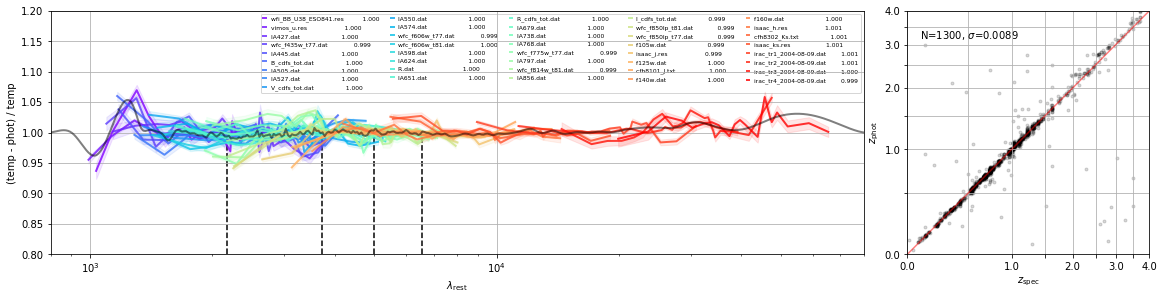

In [5]:
#translate_file = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.1.translate'%field
translate_file = '/Users/rsimons/Desktop/clear/Catalogs/%s_v4.3.translate'%field

#translate_file = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst.v4.1.cats/Eazy/%s_3dhst.v4.1.translate'%(field, field)


self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)
#self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
#                          params=params, load_prior=True, load_products=False)
NITER = 5
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    sn = self.fnu/self.efnu
    clip = (sn > 20).sum(axis=1) > 10 # Generally make this higher to ensure reasonable fits
    print(len(np.where(clip == True)[0]))
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=(iter > 0), 
                              NBIN=NBIN, get_spatial_offset=False)

Compute best fits
Fit 250.7 s (n_proc=8, NOBJ=50507)


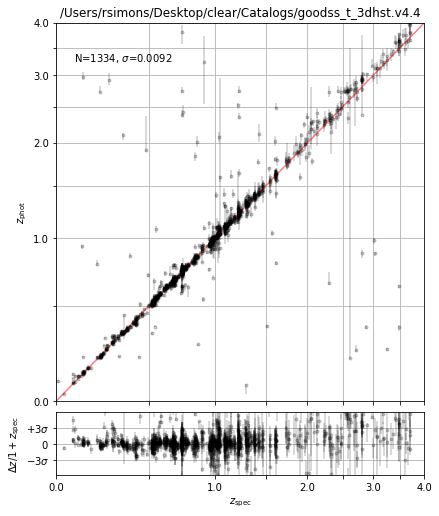

In [6]:
# Turn off error corrections derived above
self.efnu = self.efnu_orig*1

# Full catalog
sample = np.isfinite(self.cat['z_spec'])
self.fit_parallel(self.idx[sample], n_proc=8)
# Show zspec-zphot comparison
fig = self.zphot_zspec()
fig.savefig('%s_zpec_zphot.png'%field, dpi = 300)

In [7]:
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, prior=True, beta_prior=True)

Get best fit coeffs & best redshifts
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])
Rest-frame filters: [153, 154, 155, 161]


/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/photoz.py:2280: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Rest-frame filters: [270, 274, 120, 121, 156, 157, 158, 159, 160, 161, 162, 163]


In [8]:
self.standard_output?